# Classifier code for training the datasets

## Generate Datasets

In [22]:
import numpy as np
import pickle
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB#
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import time
import sys
import joblib
from itertools import combinations

#df = pd.read_csv('/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/movementLeftFoot.csv')
#df=(df-df.std())/(df.mean())
path="/its/home/drs25/GonkRobot/Data/raw/"
if sys.platform.startswith('win'):
    path="C:/Users/dexte/Documents/GitHub/TactileSensor/Code/Data collection/robot/New_feet/raw/"
df = pd.read_csv(path+'carpet_d1.1_raw_L.csv')
#df=(df-df.std())/(df.mean())

print(df.keys())

torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.version.cuda)
print("GPU:",torch.cuda.is_available())
def get_foot_image(processed): #get the image of an array
    grid=np.zeros((3,5))
    grid[2][4]=processed[0]
    grid[2][3]=processed[1]
    grid[2][2]=processed[2]
    grid[2][1]=processed[3]
    grid[2][0]=processed[4]

    grid[1][3]=processed[8]
    grid[1][2]=processed[9]
    grid[1][1]=processed[6]
    grid[1][0]=processed[5]

    grid[0][4]=processed[10]
    grid[0][3]=processed[11]
    grid[0][2]=processed[12]
    grid[0][1]=processed[13]
    grid[0][0]=processed[14]
    grid=(grid-np.min(grid))/(np.max(grid)-np.min(grid))
    return grid

def genDataSet(var,texture=False,days=True,left=True,right=True):
    if right and not left:
        X,y=sort_data("wood_d1_raw_R.csv",var)
    elif left and not right:
        X,y=sort_data("wood_d1_raw_L.csv",var)
    if right:
        X1,y1=sort_data("wood_d2.1_raw_R.csv",var)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("wood_d2.3_raw_R.csv",var)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("wood_d2_raw_R.csv",var)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
    if left:
        if not right:
            X1,y1=sort_data("wood_d1_raw_L.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("wood_d2.1_raw_L.csv",var)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
    if texture:
        if left:
            X1,y1=sort_data("carpet_d1.1_raw_L.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("carpet_d1_raw_L.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("concrete_d2_raw_L.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("concrete_d2.1_raw_L.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("RoughRock_d3_raw_L.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("Smooth_d4_raw_L.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
        if right:
            X1,y1=sort_data("carpet_d1_raw_R.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("carpet_d1.1_raw_R.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("concrete_d2_raw_R.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("concrete_d2.1_raw_R.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("RoughRock_d3_raw_R.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("Smooth_d4_raw_R.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
        if days:
            if left:
                X1,y1=sort_data("Carpet_d4_raw_L.csv",var)
                X=np.concatenate((X,X1),axis=0)
                y=np.concatenate((y,y1),axis=0)
            if right:
                X1,y1=sort_data("Carpet_d4_raw_R.csv",var)
                X=np.concatenate((X,X1),axis=0)
                y=np.concatenate((y,y1),axis=0)
    return X,y

def sort_data(name,vibration=True,dir="all"):
    df = pd.read_csv(path+name)
    df=pd.DataFrame(df).fillna(0)
    if vibration:
        ar=[]
        for key in list(df.keys()):
            if key not in ["time_step","x","y","z"]:
                ar.append(df[key])
        x=np.array(ar)
    else: #return without vibration data
        ar=[]
        for key in list(df.keys()):
            if key not in ["time_step","x","y","z","s_1_7","s_2_7"]:
                ar.append(df[key])
        x=np.array(ar)
    if dir=="left":
        ar=[]
        for key in list(df.keys()):
            if key not in ["time_step","x","y","z"] and "s_1" in key:
                ar.append(df[key])
        x=np.array(ar)
    elif dir=="right":
        ar=[]
        for key in list(df.keys()):
            if key not in ["x","y","z"] and "s_2" in key:
                ar.append(df[key])
        x=np.array(ar)
    x=x.T #transpose to have layers
    y=np.array([df['x'],df['y'],df['z']])
    y=y.T
    nan_indices = np.where(np.isnan(y))
    y[nan_indices]=0
    print("X data:",x.shape,"/ny data:",y.shape)
    return x,y

def getReductionMatrix(filename):
    x,y=sort_data(filename,vibration=True,dir="all") #loop through file name
    reduction = np.average(x,axis=0)
    return reduction

def gen_temporal_data(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,X.shape[1]*T))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.concatenate(ar,axis=0)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y

def gen_temporal_data_2(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,T,X.shape[1]))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.array(ar)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y


def reduction_matrix(x_standard):
    return np.average(x_standard,axis=0)


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SimpleNN, self).__init__()

        # Create a list to store the layers of the neural network
        layers = []

        # Add the input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())  # You can use other activation functions as well
        #print(layers[0].weight.dtype)
        # Add the hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())  # You can use other activation functions as well

        # Add the output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))

        # Combine all layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Define the forward pass of the network
        return self.model(x)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagation
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

def train(X_train,Y_train,X_test,Y_test,batch_size=64,num_epochs = 100,learning_rate = 0.01,acc_check=0):
    # Split your dataset into training and validation sets
    # train_data, val_data = ...
    lstm_model=LSTMModel(X_train.shape[2],500,2,Y_train.shape[1]).to(device)
    # Create data loaders for training and validation

    # Initialize the optimizer
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    history_train=[]
    history_test=[]
    # Training loop
    for epoch in range(num_epochs):
        lstm_model.train()
        total_loss=0
        for i in range(0,len(X_train)-batch_size,batch_size):
            optimizer.zero_grad()
            # Forward pass
            batch=X_train[i:i+batch_size]
            outputs = lstm_model(batch.to(device))

            # Calculate the loss
            batch=Y_train[i:i+batch_size]
            loss = criterion(outputs, batch.to(device))

            # Backpropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        history_train.append(total_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")
    return history_train, history_test, lstm_model

Index(['time_step', 'x', 'y', 'z', 's_1_0', 's_1_1', 's_1_2', 's_1_3', 's_1_4',
       's_1_5', 's_1_6', 's_1_7', 's_1_8', 's_1_9', 's_1_10', 's_1_11',
       's_1_12', 's_1_13', 's_1_14', 's_1_15', 's_2_0', 's_2_1', 's_2_2',
       's_2_3', 's_2_4', 's_2_5', 's_2_6', 's_2_7', 's_2_8', 's_2_9', 's_2_10',
       's_2_11', 's_2_12', 's_2_13', 's_2_14', 's_2_15'],
      dtype='object')
11.8
GPU: True


## Regress orientation

This section takes in a temporal window of tactile data and classifies which texture it is belonging to

In [2]:
var=1
X,y=sort_data("wood_d1_raw_R.csv",var)
X1,y1=sort_data("wood_d1_raw_L.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d2.1_raw_L.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d2.1_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d2.3_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d2_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

wood_X=X.copy()
wood_y=y.copy()

X,y=sort_data("carpet_d1.1_raw_L.csv",var)
X1,y1=sort_data("carpet_d1.1_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("carpet_d1_raw_L.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("carpet_d1_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

carpet_x=X.copy()
carpet_y=y.copy()

X,y=sort_data("concrete_d2_raw_L.csv",var)
X1,y1=sort_data("concrete_d2_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("concrete_d2.1_raw_L.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("concrete_d2.1_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

concrete_X=X.copy()
concrete_y=y.copy()

X,y=sort_data("Smooth_d4_raw_L.csv",var)
X1,y1=sort_data("Smooth_d4_raw_R.csv",var)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

smooth_X=X.copy()
smooth_y=y.copy()
print(concrete_X.shape,carpet_x.shape,wood_X.shape,smooth_X.shape)
print(concrete_y.shape,carpet_y.shape,wood_y.shape,smooth_y.shape)

X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
(17100, 32) (17100, 32) (24300, 32) (8550, 32)
(17100, 3) (17100, 3) (24300, 3) (8550, 3)


In [ ]:
# Look at differences in readings

datasets=[concrete_X.flatten(),carpet_x.flatten(),wood_X.flatten(),smooth_X.flatten()]
labels=["Rough concrete","Carpet","Wood","Smooth concrete"]
fig, ax = plt.subplots()
ax.set_ylabel('Pressures')
bplot = ax.boxplot(datasets,
                   patch_artist=True,  # fill with color
                   tick_labels=labels)  # will be used to label x-ticks
ax.set_title("Pressure readings across textures")        
plt.tight_layout()
plt.savefig("/its/home/drs25/GonkRobot/assets/pressure_freq.pdf")
plt.show()

### Random forrest 

In [34]:
def runRF(t=80):
    X=np.concatenate([concrete_X,carpet_x,wood_X,smooth_X])
    y=np.concatenate([concrete_y,carpet_y,wood_y,smooth_y])

    X,y=gen_temporal_data(X,y,t)
    print(X.shape,y.shape)
    X=(X-np.mean(X))/(np.std(X))

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestRegressor(n_estimators=25)

    # Train the classifier on the training data
    rf_classifier.fit(X_train, y_train)
    
    joblib.dump(rf_classifier, "/its/home/drs25/GonkRobot/Data/model/my_random_forest.joblib")
    # Make predictions on the test data
    predictions_train = rf_classifier.predict(X_train)
    predictions_test = rf_classifier.predict(X_test)

    mse1 = mean_squared_error(y_train, predictions_train)
    mse2 = mean_squared_error(y_test, predictions_test)
    print("Train:",mse1,"Test:",mse2)
    return mse1,mse2

### Ridge

In [83]:
def runRidge(t=80):
    X=np.concatenate([concrete_X,carpet_x,wood_X,smooth_X])
    y=np.concatenate([concrete_y,carpet_y,wood_y,smooth_y])
    X,y=gen_temporal_data(X,y,t)
    X=(X-np.mean(X))/(np.std(X))
    print(X.shape,y.shape)
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    ridge = Ridge(alpha=1)

    # Train the classifier on the training data
    ridge.fit(X_train, y_train)

    # Make predictions on the test data
    predictions_train = ridge.predict(X_train)
    predictions_test = ridge.predict(X_test)
    joblib.dump(ridge, "/its/home/drs25/GonkRobot/Data/model/ridge.joblib")
    mse1 = mean_squared_error(y_train, predictions_train)
    mse2 = mean_squared_error(y_test, predictions_test)
    print("Train:",mse1,"Test:",mse2)
    return mse1,mse2


(66970, 2560) (66970, 3)
Train: 0.43463891383888625 Test: 0.47106241662043646


(np.float64(0.43463891383888625), np.float64(0.47106241662043646))

### FNN

In [20]:
def runFNN(t=80,X=None,y=None):
    if type(X)==type(None):
        X=np.concatenate([concrete_X,carpet_x,wood_X,smooth_X])
        y=np.concatenate([concrete_y,carpet_y,wood_y,smooth_y])
        X,y=gen_temporal_data(X,y,t)
        X=(X-np.mean(X))/(np.std(X))
        y=(y-np.mean(y))/(np.std(y))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train=torch.tensor(X_train,dtype=torch.float32).to(device)
    y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
    model = SimpleNN(len(X_train[0]), [500,50], 3).to(device)

    # Define the loss function and the optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    num_epochs=2000

    for epoch in range(num_epochs):
        total_loss = 0.0

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)

        # Calculate the loss
        loss = criterion(outputs, y_train)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print the average loss for the epoch
        average_loss = total_loss 
        if epoch%100==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

    predictions_train = model(X_train)
    predictions_test = model(torch.tensor(X_test,dtype=torch.float32).to(device))

    mse1 = mean_squared_error(y_train.cpu().detach().numpy(), predictions_train.cpu().detach().numpy())
    mse2 = mean_squared_error(y_test, predictions_test.cpu().detach().numpy())
    
    torch.save(model.state_dict(), "/its/home/drs25/GonkRobot/Data/model/ANN")
    print("Train:",mse1,"Test:",mse2)
    return mse1,mse2
runFNN()

Epoch [1/2000], Loss: 1.0275
Epoch [101/2000], Loss: 0.0781
Epoch [201/2000], Loss: 0.0595
Epoch [301/2000], Loss: 0.0482
Epoch [401/2000], Loss: 0.0417
Epoch [501/2000], Loss: 0.0375
Epoch [601/2000], Loss: 0.0346
Epoch [701/2000], Loss: 0.0323
Epoch [801/2000], Loss: 0.0306
Epoch [901/2000], Loss: 0.0292
Epoch [1001/2000], Loss: 0.0279
Epoch [1101/2000], Loss: 0.0268
Epoch [1201/2000], Loss: 0.0259
Epoch [1301/2000], Loss: 0.0251
Epoch [1401/2000], Loss: 0.0244
Epoch [1501/2000], Loss: 0.0238
Epoch [1601/2000], Loss: 0.0233
Epoch [1701/2000], Loss: 0.0228
Epoch [1801/2000], Loss: 0.0233
Epoch [1901/2000], Loss: 0.0232
Train: 0.022799509 Test: 0.0222475777820072


(np.float32(0.022799509), np.float64(0.0222475777820072))

### LSTM


In [81]:
def runLSTM(t=80):
    X=np.concatenate([concrete_X,carpet_x,wood_X,smooth_X])
    y=np.concatenate([concrete_y,carpet_y,wood_y,smooth_y])
    X,y=gen_temporal_data_2(X,y,t)
    X=(X-np.mean(X))/(np.std(X))
    y=(y-np.mean(y))/(np.std(y))

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train=torch.tensor(X_train,dtype=torch.float32)#.to(device)
    y_train=torch.tensor(y_train,dtype=torch.float32)#.to(device)
    X_test=torch.tensor(X_test,dtype=torch.float32)
    y_test=torch.tensor(y_test,dtype=torch.float32)

    lossTrain,lossTest,model=train(X_train,y_train,X_test,y_test,num_epochs = 300,learning_rate = 0.01)

    plt.plot(lossTrain)
    plt.plot(lossTest)
    plt.show()
    torch.save(model.state_dict(), "/its/home/drs25/GonkRobot/Data/model/LSTM")
    predictions_train = model(X_train[0:200].to(device))
    predictions_test = model(X_test[0:200].to(device))

    mse1 = mean_squared_error(y_train[0:200], predictions_train.cpu().detach().numpy())
    mse2 = mean_squared_error(y_test[0:200], predictions_test.cpu().detach().numpy())
    print("Train:",mse1,"Test:",mse2)
    
    return mse1,mse2

### T plotting experiment

In [31]:
T=[]
for i in range(1,50,2):
    T.append(runRidge(t=i))
T=np.array(T)
np.save("/its/home/drs25/GonkRobot/Data/experimentdata/Ridge_T",T)

(67049, 32) (67049, 3)
Train: 1.012439659739717 Test: 0.9647149271352875
(67047, 96) (67047, 3)
Train: 0.9127308672761898 Test: 0.9301178519887445
(67045, 160) (67045, 3)
Train: 0.8601876395576274 Test: 0.8626858503443758
(67043, 224) (67043, 3)
Train: 0.8209592083348962 Test: 0.7942078288221648
(67041, 288) (67041, 3)
Train: 0.77539727929914 Test: 0.805756331666771
(67039, 352) (67039, 3)
Train: 0.7548088130719693 Test: 0.755453959261982
(67037, 416) (67037, 3)
Train: 0.7322636333851547 Test: 0.7279043120231742
(67035, 480) (67035, 3)
Train: 0.7077879454937782 Test: 0.709683378686568
(67033, 544) (67033, 3)
Train: 0.6854699469124776 Test: 0.699021199227127
(67031, 608) (67031, 3)
Train: 0.6749237393137705 Test: 0.6575968859763054
(67029, 672) (67029, 3)
Train: 0.6480347820962182 Test: 0.700527771235668
(67027, 736) (67027, 3)
Train: 0.6355430420176117 Test: 0.6936527037684854
(67025, 800) (67025, 3)
Train: 0.6378941892898297 Test: 0.6310650464704591
(67023, 864) (67023, 3)
Train: 0.61

In [61]:
T=[]
for i in range(1,50,2):
    t=[]
    for j in range(5):
        t.append(runFNN(t=i))
    T.append(t)
T=np.array(T)
np.save("/its/home/drs25/GonkRobot/Data/experimentdata/FNN_T",T)

Epoch [1/5000], Loss: 1.2411
Epoch [101/5000], Loss: 0.0555
Epoch [201/5000], Loss: 0.0449
Epoch [301/5000], Loss: 0.0394
Epoch [401/5000], Loss: 0.0371
Epoch [501/5000], Loss: 0.0359
Epoch [601/5000], Loss: 0.0349
Epoch [701/5000], Loss: 0.0305
Epoch [801/5000], Loss: 0.0290
Epoch [901/5000], Loss: 0.0274
Epoch [1001/5000], Loss: 0.0275
Epoch [1101/5000], Loss: 0.0261
Epoch [1201/5000], Loss: 0.0257
Epoch [1301/5000], Loss: 0.0257
Epoch [1401/5000], Loss: 0.0250
Epoch [1501/5000], Loss: 0.0247
Epoch [1601/5000], Loss: 0.0206
Epoch [1701/5000], Loss: 0.0204
Epoch [1801/5000], Loss: 0.0192
Epoch [1901/5000], Loss: 0.0187
Epoch [2001/5000], Loss: 0.0185
Epoch [2101/5000], Loss: 0.0183
Epoch [2201/5000], Loss: 0.0179
Epoch [2301/5000], Loss: 0.0177
Epoch [2401/5000], Loss: 0.0180
Epoch [2501/5000], Loss: 0.0171
Epoch [2601/5000], Loss: 0.0174
Epoch [2701/5000], Loss: 0.0167
Epoch [2801/5000], Loss: 0.0164
Epoch [2901/5000], Loss: 0.0163
Epoch [3001/5000], Loss: 0.0162
Epoch [3101/5000], L

Epoch [1/300], Loss: 231.0197
Validation Loss: 0.2090
Epoch [2/300], Loss: 169.6963
Epoch [3/300], Loss: 151.9532
Epoch [4/300], Loss: 120.6021
Epoch [5/300], Loss: 97.4050
Epoch [6/300], Loss: 87.5283
Epoch [7/300], Loss: 79.6416
Epoch [8/300], Loss: 72.4573
Epoch [9/300], Loss: 66.6332
Epoch [10/300], Loss: 62.4564
Epoch [11/300], Loss: 59.5919
Epoch [12/300], Loss: 57.5079
Epoch [13/300], Loss: 55.8361
Epoch [14/300], Loss: 54.3916
Epoch [15/300], Loss: 53.0873
Epoch [16/300], Loss: 51.8780
Epoch [17/300], Loss: 50.7374
Epoch [18/300], Loss: 49.6491
Epoch [19/300], Loss: 48.6046
Epoch [20/300], Loss: 47.6019
Epoch [21/300], Loss: 46.6433
Epoch [22/300], Loss: 45.7321
Epoch [23/300], Loss: 44.8708
Epoch [24/300], Loss: 44.0602
Epoch [25/300], Loss: 43.2997
Epoch [26/300], Loss: 42.5882
Epoch [27/300], Loss: 41.9245
Epoch [28/300], Loss: 41.3072
Epoch [29/300], Loss: 40.7347
Epoch [30/300], Loss: 40.2051
Epoch [31/300], Loss: 39.7162
Epoch [32/300], Loss: 39.2655
Epoch [33/300], Loss:

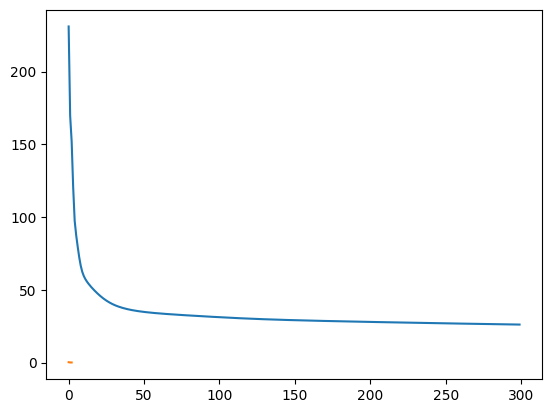

Train: 0.031136015 Test: 0.02936794
Epoch [1/300], Loss: 230.7953
Validation Loss: 0.2097
Epoch [2/300], Loss: 170.6747
Epoch [3/300], Loss: 154.3814
Epoch [4/300], Loss: 124.0747
Epoch [5/300], Loss: 98.8966
Epoch [6/300], Loss: 88.2765
Epoch [7/300], Loss: 80.3242
Epoch [8/300], Loss: 73.0467
Epoch [9/300], Loss: 67.0991
Epoch [10/300], Loss: 62.8214
Epoch [11/300], Loss: 59.8966
Epoch [12/300], Loss: 57.7771
Epoch [13/300], Loss: 56.0780
Epoch [14/300], Loss: 54.6086
Epoch [15/300], Loss: 53.2824
Epoch [16/300], Loss: 52.0573
Epoch [17/300], Loss: 50.9103
Epoch [18/300], Loss: 49.8274
Epoch [19/300], Loss: 48.7997
Epoch [20/300], Loss: 47.8209
Epoch [21/300], Loss: 46.8855
Epoch [22/300], Loss: 45.9896
Epoch [23/300], Loss: 45.1303
Epoch [24/300], Loss: 44.3068
Epoch [25/300], Loss: 43.5199
Epoch [26/300], Loss: 42.7712
Epoch [27/300], Loss: 42.0619
Epoch [28/300], Loss: 41.3930
Epoch [29/300], Loss: 40.7646
Epoch [30/300], Loss: 40.1765
Epoch [31/300], Loss: 39.6282
Epoch [32/300],

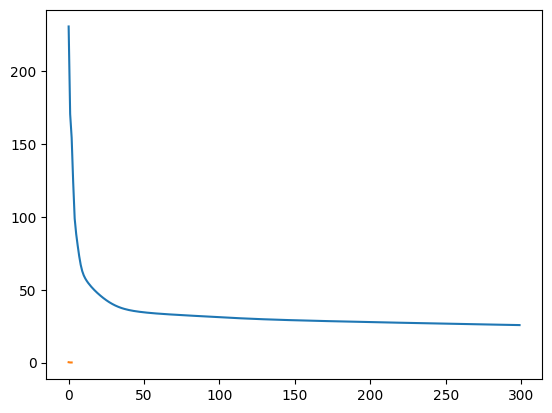

Train: 0.03068167 Test: 0.028927818
Epoch [1/300], Loss: 230.2128
Validation Loss: 0.2087
Epoch [2/300], Loss: 169.5567
Epoch [3/300], Loss: 152.1751
Epoch [4/300], Loss: 121.2661
Epoch [5/300], Loss: 97.9328
Epoch [6/300], Loss: 88.0252
Epoch [7/300], Loss: 80.1715
Epoch [8/300], Loss: 72.9627
Epoch [9/300], Loss: 67.0638
Epoch [10/300], Loss: 62.8061
Epoch [11/300], Loss: 59.8907
Epoch [12/300], Loss: 57.7867
Epoch [13/300], Loss: 56.1111
Epoch [14/300], Loss: 54.6667
Epoch [15/300], Loss: 53.3585
Epoch [16/300], Loss: 52.1383
Epoch [17/300], Loss: 50.9828
Epoch [18/300], Loss: 49.8852
Epoch [19/300], Loss: 48.8453
Epoch [20/300], Loss: 47.8625
Epoch [21/300], Loss: 46.9346
Epoch [22/300], Loss: 46.0587
Epoch [23/300], Loss: 45.2317
Epoch [24/300], Loss: 44.4513
Epoch [25/300], Loss: 43.7155
Epoch [26/300], Loss: 43.0225
Epoch [27/300], Loss: 42.3709
Epoch [28/300], Loss: 41.7592
Epoch [29/300], Loss: 41.1858
Epoch [30/300], Loss: 40.6489
Epoch [31/300], Loss: 40.1461
Epoch [32/300],

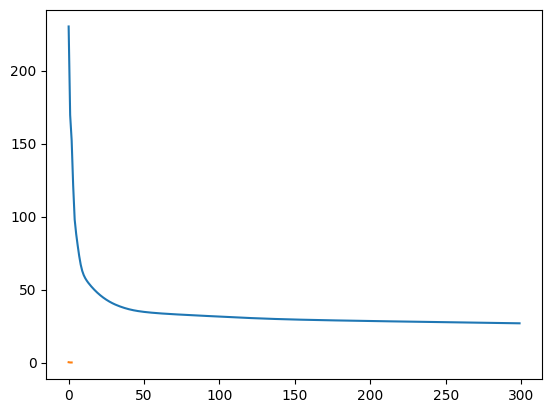

Train: 0.032058228 Test: 0.030276356
Epoch [1/300], Loss: 232.2344
Validation Loss: 0.2097
Epoch [2/300], Loss: 170.7275
Epoch [3/300], Loss: 154.5309
Epoch [4/300], Loss: 124.1560
Epoch [5/300], Loss: 98.5637
Epoch [6/300], Loss: 87.9084
Epoch [7/300], Loss: 80.1023
Epoch [8/300], Loss: 72.9880
Epoch [9/300], Loss: 67.1513
Epoch [10/300], Loss: 62.9037
Epoch [11/300], Loss: 59.9605
Epoch [12/300], Loss: 57.8130
Epoch [13/300], Loss: 56.0903
Epoch [14/300], Loss: 54.6001
Epoch [15/300], Loss: 53.2508
Epoch [16/300], Loss: 51.9957
Epoch [17/300], Loss: 50.8099
Epoch [18/300], Loss: 49.6812
Epoch [19/300], Loss: 48.6054
Epoch [20/300], Loss: 47.5806
Epoch [21/300], Loss: 46.6055
Epoch [22/300], Loss: 45.6775
Epoch [23/300], Loss: 44.7943
Epoch [24/300], Loss: 43.9534
Epoch [25/300], Loss: 43.1527
Epoch [26/300], Loss: 42.3906
Epoch [27/300], Loss: 41.6663
Epoch [28/300], Loss: 40.9795
Epoch [29/300], Loss: 40.3308
Epoch [30/300], Loss: 39.7211
Epoch [31/300], Loss: 39.1513
Epoch [32/300]

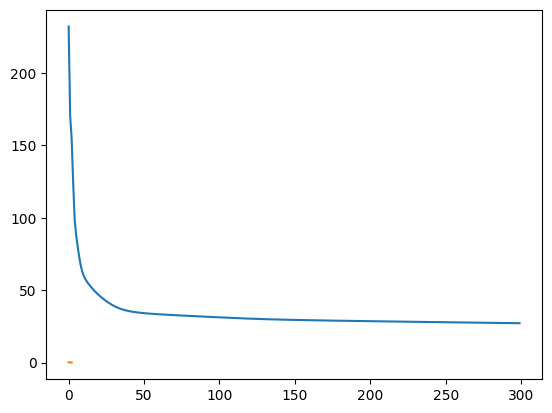

Train: 0.0323993 Test: 0.030636316
Epoch [1/300], Loss: 229.5712
Validation Loss: 0.2104
Epoch [2/300], Loss: 171.7262
Epoch [3/300], Loss: 157.1832
Epoch [4/300], Loss: 128.1896
Epoch [5/300], Loss: 100.2725
Epoch [6/300], Loss: 88.4512
Epoch [7/300], Loss: 80.6130
Epoch [8/300], Loss: 73.5199
Epoch [9/300], Loss: 67.6497
Epoch [10/300], Loss: 63.3311
Epoch [11/300], Loss: 60.3391
Epoch [12/300], Loss: 58.1930
Epoch [13/300], Loss: 56.5108
Epoch [14/300], Loss: 55.0831
Epoch [15/300], Loss: 53.8085
Epoch [16/300], Loss: 52.6368
Epoch [17/300], Loss: 51.5419
Epoch [18/300], Loss: 50.5084
Epoch [19/300], Loss: 49.5271
Epoch [20/300], Loss: 48.5922
Epoch [21/300], Loss: 47.7001
Epoch [22/300], Loss: 46.8483
Epoch [23/300], Loss: 46.0354
Epoch [24/300], Loss: 45.2611
Epoch [25/300], Loss: 44.5253
Epoch [26/300], Loss: 43.8284
Epoch [27/300], Loss: 43.1709
Epoch [28/300], Loss: 42.5533
Epoch [29/300], Loss: 41.9756
Epoch [30/300], Loss: 41.4371
Epoch [31/300], Loss: 40.9372
Epoch [32/300],

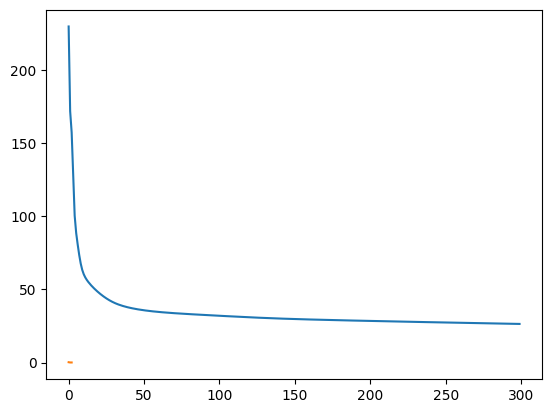

Train: 0.031456035 Test: 0.029555688
Epoch [1/300], Loss: 193.4029
Validation Loss: 0.1458
Epoch [2/300], Loss: 94.5145
Epoch [3/300], Loss: 73.1968
Epoch [4/300], Loss: 61.6294
Epoch [5/300], Loss: 55.4929
Epoch [6/300], Loss: 51.7961
Epoch [7/300], Loss: 48.8907
Epoch [8/300], Loss: 46.3495
Epoch [9/300], Loss: 44.0940
Epoch [10/300], Loss: 42.1185
Epoch [11/300], Loss: 40.4202
Epoch [12/300], Loss: 38.9858
Epoch [13/300], Loss: 37.7916
Epoch [14/300], Loss: 36.8070
Epoch [15/300], Loss: 35.9973
Epoch [16/300], Loss: 35.3284
Epoch [17/300], Loss: 34.7690
Epoch [18/300], Loss: 34.2934
Epoch [19/300], Loss: 33.8814
Epoch [20/300], Loss: 33.5178
Epoch [21/300], Loss: 33.1906
Epoch [22/300], Loss: 32.8915
Epoch [23/300], Loss: 32.6137
Epoch [24/300], Loss: 32.3525
Epoch [25/300], Loss: 32.1042
Epoch [26/300], Loss: 31.8663
Epoch [27/300], Loss: 31.6368
Epoch [28/300], Loss: 31.4146
Epoch [29/300], Loss: 31.1989
Epoch [30/300], Loss: 30.9897
Epoch [31/300], Loss: 30.7867
Epoch [32/300], L

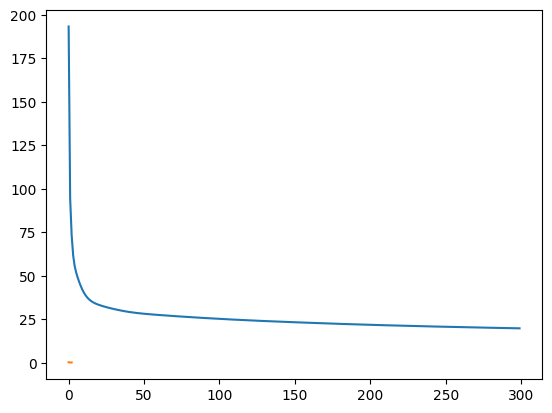

Train: 0.02341228 Test: 0.023887461
Epoch [1/300], Loss: 195.6399
Validation Loss: 0.1461
Epoch [2/300], Loss: 93.7675
Epoch [3/300], Loss: 72.4863
Epoch [4/300], Loss: 61.5417
Epoch [5/300], Loss: 55.7570
Epoch [6/300], Loss: 52.2421
Epoch [7/300], Loss: 49.5286
Epoch [8/300], Loss: 47.1947
Epoch [9/300], Loss: 45.1141
Epoch [10/300], Loss: 43.2387
Epoch [11/300], Loss: 41.5497
Epoch [12/300], Loss: 40.0440
Epoch [13/300], Loss: 38.7255
Epoch [14/300], Loss: 37.5965
Epoch [15/300], Loss: 36.6506
Epoch [16/300], Loss: 35.8702
Epoch [17/300], Loss: 35.2289
Epoch [18/300], Loss: 34.6960
Epoch [19/300], Loss: 34.2430
Epoch [20/300], Loss: 33.8472
Epoch [21/300], Loss: 33.4918
Epoch [22/300], Loss: 33.1661
Epoch [23/300], Loss: 32.8628
Epoch [24/300], Loss: 32.5772
Epoch [25/300], Loss: 32.3064
Epoch [26/300], Loss: 32.0484
Epoch [27/300], Loss: 31.8021
Epoch [28/300], Loss: 31.5662
Epoch [29/300], Loss: 31.3403
Epoch [30/300], Loss: 31.1237
Epoch [31/300], Loss: 30.9159
Epoch [32/300], Lo

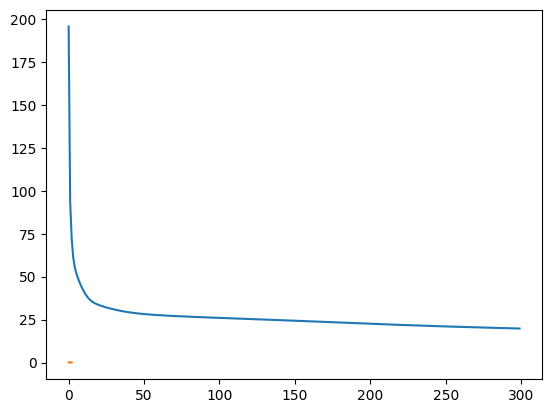

Train: 0.023524344 Test: 0.024015106
Epoch [1/300], Loss: 191.6456
Validation Loss: 0.1459
Epoch [2/300], Loss: 94.6645
Epoch [3/300], Loss: 73.3352
Epoch [4/300], Loss: 61.7311
Epoch [5/300], Loss: 55.6095
Epoch [6/300], Loss: 51.9520
Epoch [7/300], Loss: 49.1064
Epoch [8/300], Loss: 46.6385
Epoch [9/300], Loss: 44.4469
Epoch [10/300], Loss: 42.5083
Epoch [11/300], Loss: 40.8202
Epoch [12/300], Loss: 39.3816
Epoch [13/300], Loss: 38.1828
Epoch [14/300], Loss: 37.2013
Epoch [15/300], Loss: 36.4034
Epoch [16/300], Loss: 35.7517
Epoch [17/300], Loss: 35.2105
Epoch [18/300], Loss: 34.7513
Epoch [19/300], Loss: 34.3527
Epoch [20/300], Loss: 33.9992
Epoch [21/300], Loss: 33.6798
Epoch [22/300], Loss: 33.3873
Epoch [23/300], Loss: 33.1159
Epoch [24/300], Loss: 32.8619
Epoch [25/300], Loss: 32.6220
Epoch [26/300], Loss: 32.3936
Epoch [27/300], Loss: 32.1748
Epoch [28/300], Loss: 31.9638
Epoch [29/300], Loss: 31.7594
Epoch [30/300], Loss: 31.5607
Epoch [31/300], Loss: 31.3672
Epoch [32/300], L

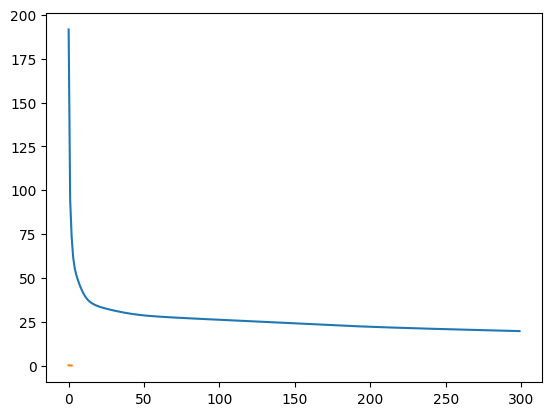

Train: 0.023332834 Test: 0.023851462
Epoch [1/300], Loss: 193.7669
Validation Loss: 0.1441
Epoch [2/300], Loss: 94.5198
Epoch [3/300], Loss: 73.8458
Epoch [4/300], Loss: 62.3448
Epoch [5/300], Loss: 56.2671
Epoch [6/300], Loss: 52.7212
Epoch [7/300], Loss: 50.0265
Epoch [8/300], Loss: 47.7086
Epoch [9/300], Loss: 45.6419
Epoch [10/300], Loss: 43.7834
Epoch [11/300], Loss: 42.1157
Epoch [12/300], Loss: 40.6341
Epoch [13/300], Loss: 39.3401
Epoch [14/300], Loss: 38.2344
Epoch [15/300], Loss: 37.3108
Epoch [16/300], Loss: 36.5530
Epoch [17/300], Loss: 35.9361
Epoch [18/300], Loss: 35.4312
Epoch [19/300], Loss: 35.0108
Epoch [20/300], Loss: 34.6512
Epoch [21/300], Loss: 34.3344
Epoch [22/300], Loss: 34.0476
Epoch [23/300], Loss: 33.7819
Epoch [24/300], Loss: 33.5313
Epoch [25/300], Loss: 33.2918
Epoch [26/300], Loss: 33.0609
Epoch [27/300], Loss: 32.8367
Epoch [28/300], Loss: 32.6183
Epoch [29/300], Loss: 32.4048
Epoch [30/300], Loss: 32.1960
Epoch [31/300], Loss: 31.9915
Epoch [32/300], L

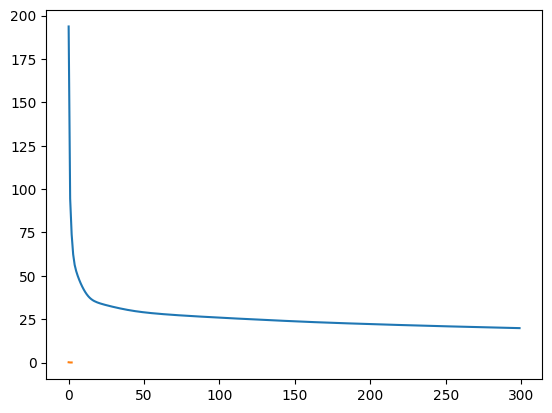

Train: 0.023571827 Test: 0.024029681
Epoch [1/300], Loss: 195.3335
Validation Loss: 0.1522
Epoch [2/300], Loss: 98.4890
Epoch [3/300], Loss: 75.9505
Epoch [4/300], Loss: 63.1241
Epoch [5/300], Loss: 56.2258
Epoch [6/300], Loss: 52.3266
Epoch [7/300], Loss: 49.3907
Epoch [8/300], Loss: 46.8818
Epoch [9/300], Loss: 44.6646
Epoch [10/300], Loss: 42.6958
Epoch [11/300], Loss: 40.9620
Epoch [12/300], Loss: 39.4645
Epoch [13/300], Loss: 38.2042
Epoch [14/300], Loss: 37.1656
Epoch [15/300], Loss: 36.3140
Epoch [16/300], Loss: 35.6059
Epoch [17/300], Loss: 35.0029
Epoch [18/300], Loss: 34.4773
Epoch [19/300], Loss: 34.0109
Epoch [20/300], Loss: 33.5924
Epoch [21/300], Loss: 33.2140
Epoch [22/300], Loss: 32.8701
Epoch [23/300], Loss: 32.5565
Epoch [24/300], Loss: 32.2691
Epoch [25/300], Loss: 32.0043
Epoch [26/300], Loss: 31.7590
Epoch [27/300], Loss: 31.5302
Epoch [28/300], Loss: 31.3154
Epoch [29/300], Loss: 31.1122
Epoch [30/300], Loss: 30.9190
Epoch [31/300], Loss: 30.7343
Epoch [32/300], L

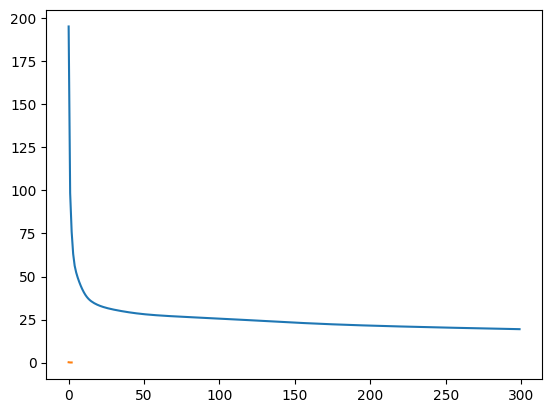

Train: 0.023024917 Test: 0.023485385
Epoch [1/300], Loss: 165.6426
Validation Loss: 0.1070
Epoch [2/300], Loss: 74.8914
Epoch [3/300], Loss: 58.3134
Epoch [4/300], Loss: 51.3805
Epoch [5/300], Loss: 47.2532
Epoch [6/300], Loss: 43.9397
Epoch [7/300], Loss: 41.1523
Epoch [8/300], Loss: 38.8484
Epoch [9/300], Loss: 37.0262
Epoch [10/300], Loss: 35.6575
Epoch [11/300], Loss: 34.6611
Epoch [12/300], Loss: 33.9266
Epoch [13/300], Loss: 33.3558
Epoch [14/300], Loss: 32.8811
Epoch [15/300], Loss: 32.4632
Epoch [16/300], Loss: 32.0813
Epoch [17/300], Loss: 31.7242
Epoch [18/300], Loss: 31.3859
Epoch [19/300], Loss: 31.0626
Epoch [20/300], Loss: 30.7521
Epoch [21/300], Loss: 30.4531
Epoch [22/300], Loss: 30.1652
Epoch [23/300], Loss: 29.8878
Epoch [24/300], Loss: 29.6217
Epoch [25/300], Loss: 29.3666
Epoch [26/300], Loss: 29.1230
Epoch [27/300], Loss: 28.8911
Epoch [28/300], Loss: 28.6711
Epoch [29/300], Loss: 28.4624
Epoch [30/300], Loss: 28.2650
Epoch [31/300], Loss: 28.0784
Epoch [32/300], L

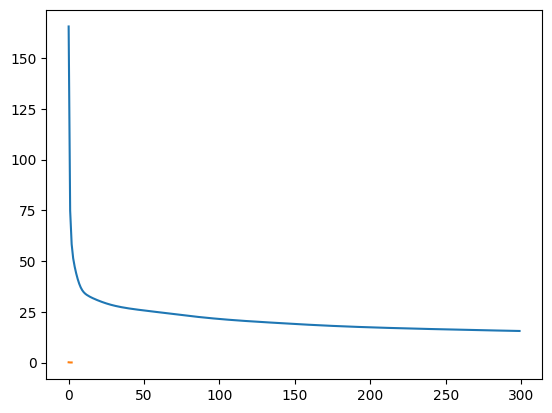

Train: 0.018325716 Test: 0.018400358
Epoch [1/300], Loss: 166.5110
Validation Loss: 0.1094
Epoch [2/300], Loss: 77.1818
Epoch [3/300], Loss: 60.1892
Epoch [4/300], Loss: 52.5870
Epoch [5/300], Loss: 48.3047
Epoch [6/300], Loss: 44.9068
Epoch [7/300], Loss: 42.0021
Epoch [8/300], Loss: 39.5298
Epoch [9/300], Loss: 37.5012
Epoch [10/300], Loss: 35.9264
Epoch [11/300], Loss: 34.7640
Epoch [12/300], Loss: 33.9205
Epoch [13/300], Loss: 33.2899
Epoch [14/300], Loss: 32.7888
Epoch [15/300], Loss: 32.3643
Epoch [16/300], Loss: 31.9868
Epoch [17/300], Loss: 31.6404
Epoch [18/300], Loss: 31.3162
Epoch [19/300], Loss: 31.0088
Epoch [20/300], Loss: 30.7150
Epoch [21/300], Loss: 30.4329
Epoch [22/300], Loss: 30.1609
Epoch [23/300], Loss: 29.8990
Epoch [24/300], Loss: 29.6466
Epoch [25/300], Loss: 29.4037
Epoch [26/300], Loss: 29.1708
Epoch [27/300], Loss: 28.9477
Epoch [28/300], Loss: 28.7345
Epoch [29/300], Loss: 28.5316
Epoch [30/300], Loss: 28.3385
Epoch [31/300], Loss: 28.1554
Epoch [32/300], L

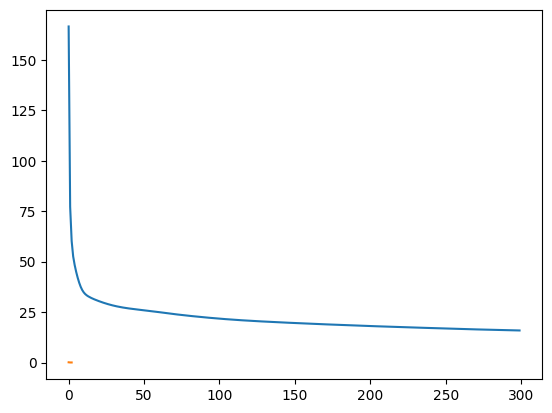

Train: 0.018710269 Test: 0.018974395
Epoch [1/300], Loss: 166.9822
Validation Loss: 0.1079
Epoch [2/300], Loss: 76.6414
Epoch [3/300], Loss: 60.5915
Epoch [4/300], Loss: 53.3362
Epoch [5/300], Loss: 49.0397
Epoch [6/300], Loss: 45.5228
Epoch [7/300], Loss: 42.4241
Epoch [8/300], Loss: 39.7183
Epoch [9/300], Loss: 37.4703
Epoch [10/300], Loss: 35.7325
Epoch [11/300], Loss: 34.4696
Epoch [12/300], Loss: 33.5647
Epoch [13/300], Loss: 32.8866
Epoch [14/300], Loss: 32.3386
Epoch [15/300], Loss: 31.8649
Epoch [16/300], Loss: 31.4364
Epoch [17/300], Loss: 31.0388
Epoch [18/300], Loss: 30.6652
Epoch [19/300], Loss: 30.3132
Epoch [20/300], Loss: 29.9815
Epoch [21/300], Loss: 29.6705
Epoch [22/300], Loss: 29.3804
Epoch [23/300], Loss: 29.1112
Epoch [24/300], Loss: 28.8627
Epoch [25/300], Loss: 28.6340
Epoch [26/300], Loss: 28.4239
Epoch [27/300], Loss: 28.2307
Epoch [28/300], Loss: 28.0527
Epoch [29/300], Loss: 27.8880
Epoch [30/300], Loss: 27.7352
Epoch [31/300], Loss: 27.5926
Epoch [32/300], L

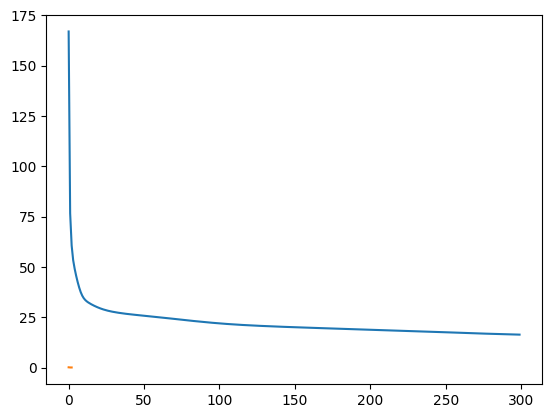

Train: 0.019351821 Test: 0.0194842
Epoch [1/300], Loss: 170.1579
Validation Loss: 0.1110
Epoch [2/300], Loss: 77.8784
Epoch [3/300], Loss: 60.7689
Epoch [4/300], Loss: 53.0191
Epoch [5/300], Loss: 48.5598
Epoch [6/300], Loss: 44.9740
Epoch [7/300], Loss: 41.8889
Epoch [8/300], Loss: 39.2588
Epoch [9/300], Loss: 37.1174
Epoch [10/300], Loss: 35.4905
Epoch [11/300], Loss: 34.3251
Epoch [12/300], Loss: 33.4970
Epoch [13/300], Loss: 32.8763
Epoch [14/300], Loss: 32.3711
Epoch [15/300], Loss: 31.9295
Epoch [16/300], Loss: 31.5257
Epoch [17/300], Loss: 31.1474
Epoch [18/300], Loss: 30.7891
Epoch [19/300], Loss: 30.4486
Epoch [20/300], Loss: 30.1253
Epoch [21/300], Loss: 29.8195
Epoch [22/300], Loss: 29.5310
Epoch [23/300], Loss: 29.2601
Epoch [24/300], Loss: 29.0067
Epoch [25/300], Loss: 28.7699
Epoch [26/300], Loss: 28.5492
Epoch [27/300], Loss: 28.3436
Epoch [28/300], Loss: 28.1519
Epoch [29/300], Loss: 27.9729
Epoch [30/300], Loss: 27.8059
Epoch [31/300], Loss: 27.6494
Epoch [32/300], Los

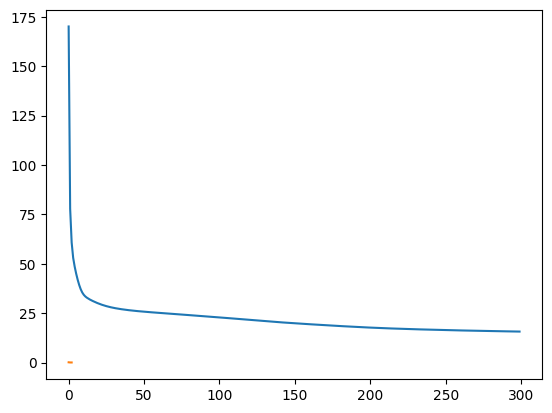

Train: 0.01842141 Test: 0.018529855
Epoch [1/300], Loss: 167.7528
Validation Loss: 0.1100
Epoch [2/300], Loss: 77.6413
Epoch [3/300], Loss: 60.4055
Epoch [4/300], Loss: 52.5899
Epoch [5/300], Loss: 48.1551
Epoch [6/300], Loss: 44.6509
Epoch [7/300], Loss: 41.6786
Epoch [8/300], Loss: 39.1805
Epoch [9/300], Loss: 37.1693
Epoch [10/300], Loss: 35.6470
Epoch [11/300], Loss: 34.5531
Epoch [12/300], Loss: 33.7744
Epoch [13/300], Loss: 33.1946
Epoch [14/300], Loss: 32.7286
Epoch [15/300], Loss: 32.3258
Epoch [16/300], Loss: 31.9593
Epoch [17/300], Loss: 31.6156
Epoch [18/300], Loss: 31.2878
Epoch [19/300], Loss: 30.9726
Epoch [20/300], Loss: 30.6686
Epoch [21/300], Loss: 30.3752
Epoch [22/300], Loss: 30.0923
Epoch [23/300], Loss: 29.8202
Epoch [24/300], Loss: 29.5594
Epoch [25/300], Loss: 29.3104
Epoch [26/300], Loss: 29.0731
Epoch [27/300], Loss: 28.8477
Epoch [28/300], Loss: 28.6342
Epoch [29/300], Loss: 28.4317
Epoch [30/300], Loss: 28.2400
Epoch [31/300], Loss: 28.0581
Epoch [32/300], Lo

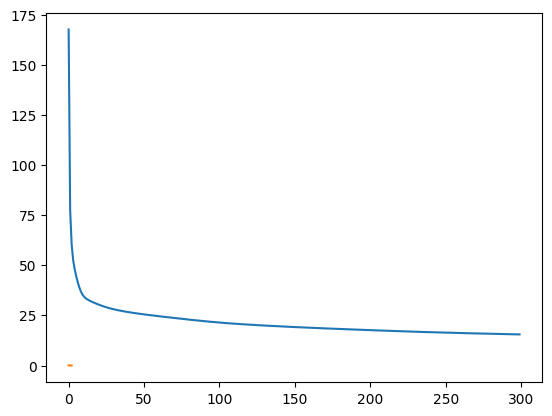

Train: 0.018217178 Test: 0.018436803
Epoch [1/300], Loss: 157.4856
Validation Loss: 0.0982
Epoch [2/300], Loss: 69.3292
Epoch [3/300], Loss: 54.8745
Epoch [4/300], Loss: 48.8739
Epoch [5/300], Loss: 44.6135
Epoch [6/300], Loss: 40.9612
Epoch [7/300], Loss: 37.8641
Epoch [8/300], Loss: 35.4719
Epoch [9/300], Loss: 33.8506
Epoch [10/300], Loss: 32.8368
Epoch [11/300], Loss: 32.1715
Epoch [12/300], Loss: 31.6697
Epoch [13/300], Loss: 31.2425
Epoch [14/300], Loss: 30.8541
Epoch [15/300], Loss: 30.4904
Epoch [16/300], Loss: 30.1454
Epoch [17/300], Loss: 29.8168
Epoch [18/300], Loss: 29.5032
Epoch [19/300], Loss: 29.2046
Epoch [20/300], Loss: 28.9214
Epoch [21/300], Loss: 28.6535
Epoch [22/300], Loss: 28.4012
Epoch [23/300], Loss: 28.1637
Epoch [24/300], Loss: 27.9403
Epoch [25/300], Loss: 27.7303
Epoch [26/300], Loss: 27.5316
Epoch [27/300], Loss: 27.3433
Epoch [28/300], Loss: 27.1639
Epoch [29/300], Loss: 26.9923
Epoch [30/300], Loss: 26.8275
Epoch [31/300], Loss: 26.6690
Epoch [32/300], L

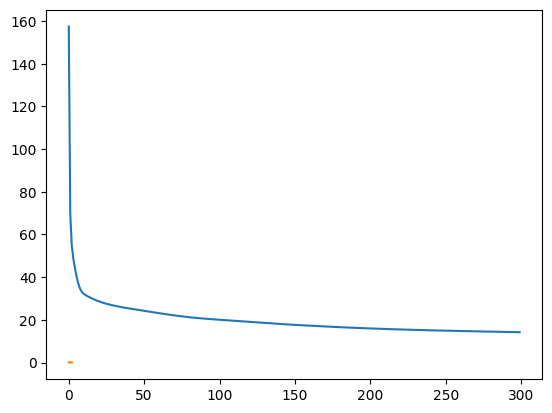

Train: 0.016643764 Test: 0.015481717
Epoch [1/300], Loss: 160.1940
Validation Loss: 0.1012
Epoch [2/300], Loss: 70.0760
Epoch [3/300], Loss: 53.9699
Epoch [4/300], Loss: 47.0423
Epoch [5/300], Loss: 42.5750
Epoch [6/300], Loss: 39.4532
Epoch [7/300], Loss: 37.0468
Epoch [8/300], Loss: 35.1693
Epoch [9/300], Loss: 33.7623
Epoch [10/300], Loss: 32.7457
Epoch [11/300], Loss: 32.0030
Epoch [12/300], Loss: 31.4272
Epoch [13/300], Loss: 30.9460
Epoch [14/300], Loss: 30.5197
Epoch [15/300], Loss: 30.1276
Epoch [16/300], Loss: 29.7595
Epoch [17/300], Loss: 29.4108
Epoch [18/300], Loss: 29.0807
Epoch [19/300], Loss: 28.7696
Epoch [20/300], Loss: 28.4787
Epoch [21/300], Loss: 28.2085
Epoch [22/300], Loss: 27.9591
Epoch [23/300], Loss: 27.7300
Epoch [24/300], Loss: 27.5196
Epoch [25/300], Loss: 27.3264
Epoch [26/300], Loss: 27.1487
Epoch [27/300], Loss: 26.9844
Epoch [28/300], Loss: 26.8324
Epoch [29/300], Loss: 26.6909
Epoch [30/300], Loss: 26.5586
Epoch [31/300], Loss: 26.4346
Epoch [32/300], L

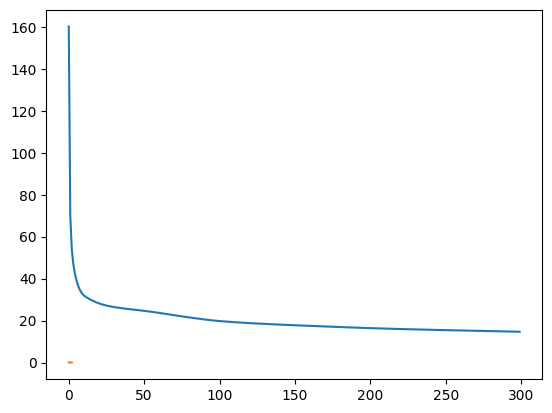

Train: 0.017214129 Test: 0.016103417
Epoch [1/300], Loss: 159.2025
Validation Loss: 0.1024
Epoch [2/300], Loss: 72.1421
Epoch [3/300], Loss: 56.2875
Epoch [4/300], Loss: 49.6673
Epoch [5/300], Loss: 45.2254
Epoch [6/300], Loss: 41.5144
Epoch [7/300], Loss: 38.3965
Epoch [8/300], Loss: 35.9718
Epoch [9/300], Loss: 34.2882
Epoch [10/300], Loss: 33.1964
Epoch [11/300], Loss: 32.4578
Epoch [12/300], Loss: 31.8952
Epoch [13/300], Loss: 31.4190
Epoch [14/300], Loss: 30.9897
Epoch [15/300], Loss: 30.5904
Epoch [16/300], Loss: 30.2134
Epoch [17/300], Loss: 29.8552
Epoch [18/300], Loss: 29.5139
Epoch [19/300], Loss: 29.1891
Epoch [20/300], Loss: 28.8811
Epoch [21/300], Loss: 28.5904
Epoch [22/300], Loss: 28.3175
Epoch [23/300], Loss: 28.0626
Epoch [24/300], Loss: 27.8253
Epoch [25/300], Loss: 27.6046
Epoch [26/300], Loss: 27.3989
Epoch [27/300], Loss: 27.2068
Epoch [28/300], Loss: 27.0260
Epoch [29/300], Loss: 26.8547
Epoch [30/300], Loss: 26.6912
Epoch [31/300], Loss: 26.5336
Epoch [32/300], L

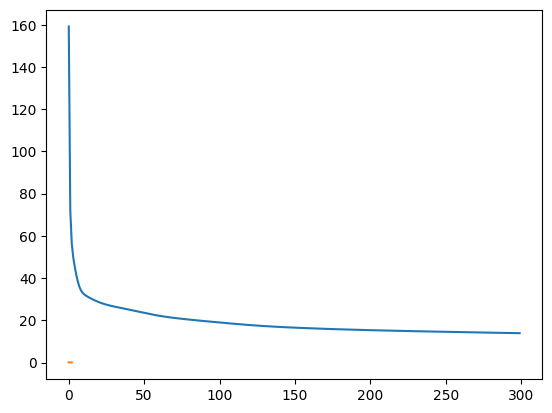

Train: 0.016318236 Test: 0.015190749
Epoch [1/300], Loss: 161.8014
Validation Loss: 0.1013
Epoch [2/300], Loss: 71.5729
Epoch [3/300], Loss: 55.8347
Epoch [4/300], Loss: 49.1687
Epoch [5/300], Loss: 44.6680
Epoch [6/300], Loss: 40.9311
Epoch [7/300], Loss: 37.8698
Epoch [8/300], Loss: 35.5578
Epoch [9/300], Loss: 33.9753
Epoch [10/300], Loss: 32.9300
Epoch [11/300], Loss: 32.1896
Epoch [12/300], Loss: 31.6010
Epoch [13/300], Loss: 31.0905
Epoch [14/300], Loss: 30.6252
Epoch [15/300], Loss: 30.1917
Epoch [16/300], Loss: 29.7854
Epoch [17/300], Loss: 29.4053
Epoch [18/300], Loss: 29.0512
Epoch [19/300], Loss: 28.7223
Epoch [20/300], Loss: 28.4166
Epoch [21/300], Loss: 28.1318
Epoch [22/300], Loss: 27.8651
Epoch [23/300], Loss: 27.6137
Epoch [24/300], Loss: 27.3743
Epoch [25/300], Loss: 27.1443
Epoch [26/300], Loss: 26.9214
Epoch [27/300], Loss: 26.7037
Epoch [28/300], Loss: 26.4903
Epoch [29/300], Loss: 26.2809
Epoch [30/300], Loss: 26.0763
Epoch [31/300], Loss: 25.8765
Epoch [32/300], L

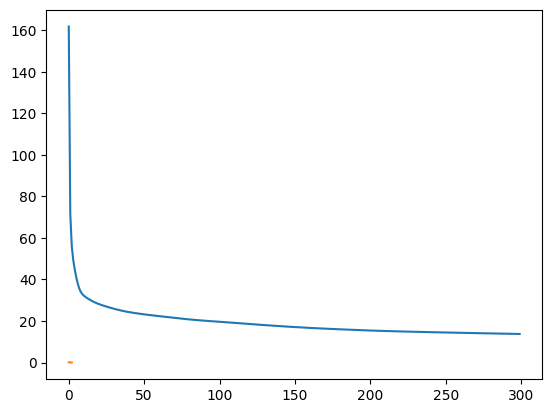

Train: 0.016185097 Test: 0.0150009915
Epoch [1/300], Loss: 152.0926
Validation Loss: 0.0955
Epoch [2/300], Loss: 67.9918
Epoch [3/300], Loss: 54.8259
Epoch [4/300], Loss: 48.8788
Epoch [5/300], Loss: 44.5413
Epoch [6/300], Loss: 40.9044
Epoch [7/300], Loss: 37.9176
Epoch [8/300], Loss: 35.6639
Epoch [9/300], Loss: 34.1303
Epoch [10/300], Loss: 33.1358
Epoch [11/300], Loss: 32.4537
Epoch [12/300], Loss: 31.9274
Epoch [13/300], Loss: 31.4778
Epoch [14/300], Loss: 31.0697
Epoch [15/300], Loss: 30.6871
Epoch [16/300], Loss: 30.3223
Epoch [17/300], Loss: 29.9708
Epoch [18/300], Loss: 29.6306
Epoch [19/300], Loss: 29.3012
Epoch [20/300], Loss: 28.9833
Epoch [21/300], Loss: 28.6781
Epoch [22/300], Loss: 28.3877
Epoch [23/300], Loss: 28.1137
Epoch [24/300], Loss: 27.8574
Epoch [25/300], Loss: 27.6189
Epoch [26/300], Loss: 27.3975
Epoch [27/300], Loss: 27.1920
Epoch [28/300], Loss: 26.9999
Epoch [29/300], Loss: 26.8197
Epoch [30/300], Loss: 26.6492
Epoch [31/300], Loss: 26.4867
Epoch [32/300], 

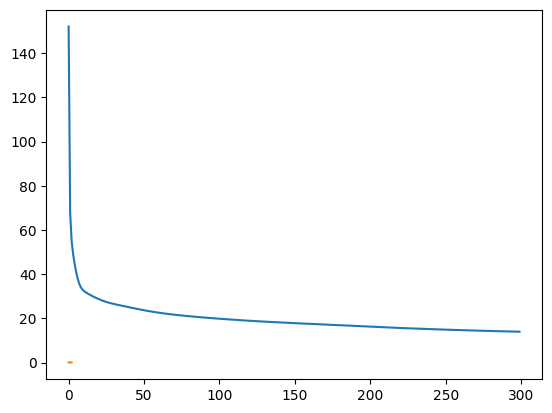

Train: 0.016327837 Test: 0.015367688
Epoch [1/300], Loss: 155.4371
Validation Loss: 0.0967
Epoch [2/300], Loss: 66.3781
Epoch [3/300], Loss: 52.2619
Epoch [4/300], Loss: 46.0674
Epoch [5/300], Loss: 41.2949
Epoch [6/300], Loss: 37.3024
Epoch [7/300], Loss: 34.3296
Epoch [8/300], Loss: 32.4786
Epoch [9/300], Loss: 31.3792
Epoch [10/300], Loss: 30.6238
Epoch [11/300], Loss: 30.0172
Epoch [12/300], Loss: 29.4842
Epoch [13/300], Loss: 28.9965
Epoch [14/300], Loss: 28.5432
Epoch [15/300], Loss: 28.1190
Epoch [16/300], Loss: 27.7210
Epoch [17/300], Loss: 27.3469
Epoch [18/300], Loss: 26.9958
Epoch [19/300], Loss: 26.6670
Epoch [20/300], Loss: 26.3595
Epoch [21/300], Loss: 26.0723
Epoch [22/300], Loss: 25.8028
Epoch [23/300], Loss: 25.5480
Epoch [24/300], Loss: 25.3039
Epoch [25/300], Loss: 25.0660
Epoch [26/300], Loss: 24.8310
Epoch [27/300], Loss: 24.5966
Epoch [28/300], Loss: 24.3620
Epoch [29/300], Loss: 24.1287
Epoch [30/300], Loss: 23.8994
Epoch [31/300], Loss: 23.6764
Epoch [32/300], L

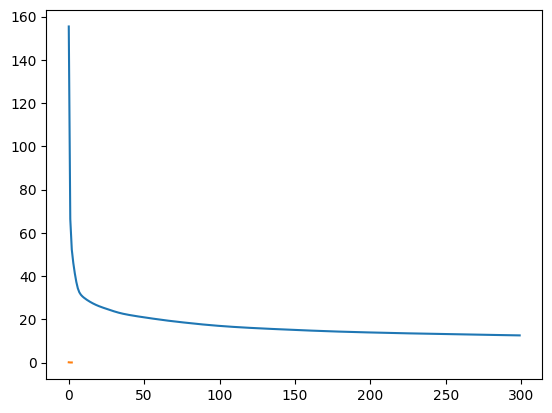

OutOfMemoryError: CUDA out of memory. Tried to allocate 9.89 GiB. GPU 0 has a total capacity of 23.59 GiB of which 8.88 GiB is free. Including non-PyTorch memory, this process has 14.42 GiB memory in use. Of the allocated memory 9.20 GiB is allocated by PyTorch, and 4.91 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [63]:
T=[]
for i in range(1,50,2):
    t=[]
    for j in range(5):
        t.append(runLSTM(t=i))
    T.append(t)
    np.save("/its/home/drs25/GonkRobot/Data/experimentdata/LSTM_T",np.array(T))

In [64]:
import joblib
T=[]
for i in range(1,50,2):
    T.append(runRF(t=i))
    np.save("/its/home/drs25/GonkRobot/Data/experimentdata/RF_T",np.array(T))

(67049, 32) (67049, 3)
Train: 0.0417168062911163 Test: 0.23245384620168844
(67047, 96) (67047, 3)
Train: 0.03367491354290689 Test: 0.23256496363992593
(67045, 160) (67045, 3)
Train: 0.03275015004768279 Test: 0.2042330581432401
(67043, 224) (67043, 3)
Train: 0.03067611183142742 Test: 0.17618943123120712
(67041, 288) (67041, 3)
Train: 0.030292594943729625 Test: 0.1993383010880784
(67039, 352) (67039, 3)
Train: 0.029927877477436915 Test: 0.18671059057649556
(67037, 416) (67037, 3)
Train: 0.029962887565539487 Test: 0.17694524606633258
(67035, 480) (67035, 3)
Train: 0.029582547559390455 Test: 0.1742793260679091
(67033, 544) (67033, 3)
Train: 0.028516786496980223 Test: 0.17743528463897015
(67031, 608) (67031, 3)
Train: 0.028596100503361463 Test: 0.16009406291445086
(67029, 672) (67029, 3)
Train: 0.02802789369778748 Test: 0.17875686182182413
(67027, 736) (67027, 3)
Train: 0.029348116030345792 Test: 0.17176614785600355
(67025, 800) (67025, 3)
Train: 0.029484927038397637 Test: 0.163975450693132

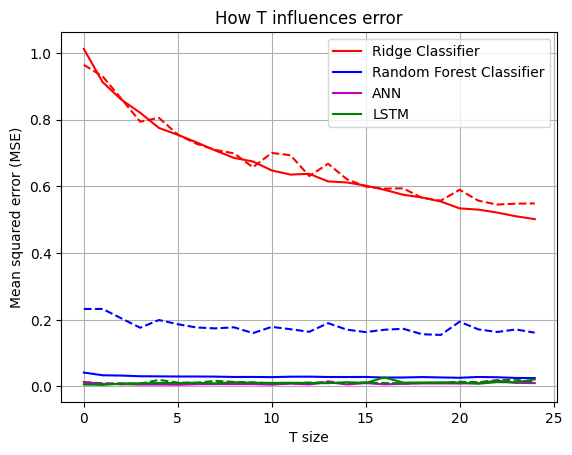

In [5]:
ridge_t=np.load("/its/home/drs25/GonkRobot/Data/experimentdata/Ridge_T.npy")
rf_t=np.load("/its/home/drs25/GonkRobot/Data/experimentdata/RF_T.npy")
ann_t=np.average(np.load("/its/home/drs25/GonkRobot/Data/experimentdata/FNN_T.npy"),axis=1)
lstm_t=np.average(np.load("/its/home/drs25/GonkRobot/Data/experimentdata/LSTM_T.npy"),axis=1)

plt.plot(ridge_t[:,0],c="r",label="Ridge Classifier")
plt.plot(ridge_t[:,1],"--",c="r")
plt.plot(rf_t[:,0],c="b",label="Random Forest Classifier")
plt.plot(rf_t[:,1],"--",c="b")
plt.plot(ann_t[:,0],c="m",label="ANN")
plt.plot(ann_t[:,1],"--",c="m")
plt.plot(lstm_t[:,0],c="g",label="LSTM")
plt.plot(lstm_t[:,1],"--",c="g")
plt.grid()
plt.ylabel("Mean squared error (MSE)")
plt.xlabel("T size")
plt.title("How T influences error")
plt.legend()
plt.savefig("/its/home/drs25/GonkRobot/assets/Tsize.pdf")
plt.show()

## Generalisation of Regression
Looking at how the models work when trained only on some textures and tested on others

In [126]:
#load in the models
loaded_rf = joblib.load("/its/home/drs25/GonkRobot/Data/model/my_random_forest.joblib")
ridge = joblib.load("/its/home/drs25/GonkRobot/Data/model/ridge.joblib")
lstm=LSTMModel(32,500,2,3).to(device)
ann=SimpleNN(2560, [500,50], 3).to(device)
ann.load_state_dict(torch.load("/its/home/drs25/GonkRobot/Data/model/ANN"))
lstm.load_state_dict(torch.load("/its/home/drs25/GonkRobot/Data/model/LSTM"))

/tmp/ipykernel_3705207/2882215557.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ann.load_state_dict(torch.load("/its/home/drs25/GonkRobot/Data/model/ANN"))
/tmp/ipyker

<All keys matched successfully>

In [175]:
# plot examples of the data and predictions for each texture and model
WINDOW=400
Xconcrete,yconcrete=gen_temporal_data(concrete_X,concrete_y,80)
Xcarpet,ycarpet=gen_temporal_data(carpet_x,carpet_y,80)
Xwood,ywood=gen_temporal_data(wood_X,wood_y,80)
Xsmooth,ysmooth=gen_temporal_data(smooth_X,smooth_y,80)
X_=np.concatenate([Xconcrete[0:WINDOW],Xcarpet[0:WINDOW],Xwood[0:WINDOW],Xsmooth[0:WINDOW]])
y_=np.concatenate([yconcrete[0:WINDOW],ycarpet[0:WINDOW],ywood[0:WINDOW],ysmooth[0:WINDOW]])
X=(X_-np.mean(X_))/(np.std(X_))
y=(y_-np.mean(y_))/(np.std(y_))
#run through models to get predictions
examples_ann=ann(torch.tensor(X,dtype=torch.float32).to(device)).cpu().detach().numpy()
examples_rf=loaded_rf.predict(X)
examples_rf=(examples_rf-np.mean(examples_rf))/(np.std(examples_rf))
examples_r=ridge.predict(X)
examples_r=(examples_r-np.mean(examples_r))/(np.std(examples_r))

Xconcrete,yconcrete=gen_temporal_data_2(concrete_X,concrete_y,80)
Xcarpet,ycarpet=gen_temporal_data_2(carpet_x,carpet_y,80)
Xwood,ywood=gen_temporal_data_2(wood_X,wood_y,80)
Xsmooth,ysmooth=gen_temporal_data_2(smooth_X,smooth_y,80)
X=np.concatenate([Xconcrete[0:WINDOW],Xcarpet[0:WINDOW],Xwood[0:WINDOW],Xsmooth[0:WINDOW]])
#y=np.concatenate([yconcrete[0:100],ycarpet[0:100],ywood[0:100],ysmooth[0:100]])
X=(X-np.mean(X))/(np.std(X))
#y=(y-np.mean(y))/(np.std(y))
examples_lstm=lstm(torch.tensor(X,dtype=torch.float32).to(device)).cpu().detach().numpy()

print(examples_lstm.shape,examples_ann.shape,X.shape,y.shape)
plt.plot(examples_ann[:,0],label="ANN")
plt.plot(examples_r[:,0],label="Ridge")
plt.plot(examples_rf[:,0],label="Random Forest")
plt.plot(examples_lstm[:,0],label="LSTM")
plt.plot(y[:,0],label="Truth")
plt.legend()
plt.show()

(1600, 3) (1600, 3) (1600, 80, 32) (1600, 3)


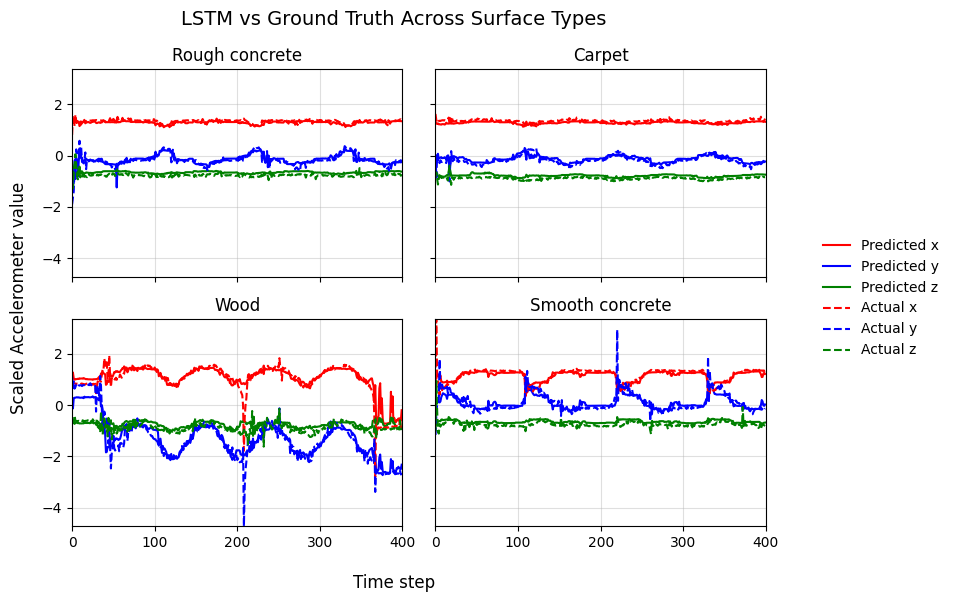

In [170]:
example=examples_lstm.copy()
temp_y=y.copy()
#example=(example*np.std(X_))+np.mean(X_)
#temp_y=(temp_y*np.std(y_))+np.mean(y_)
fig, axs = plt.subplots(
    2, 2,
    figsize=(8, 6),
    sharex=True,
    sharey=True
)
ymin = np.min([example.min(), temp_y.min()])
ymax = np.max([example.max(), temp_y.max()])
axs = axs.flatten()
labels=["Rough concrete","Carpet","Wood","Smooth concrete"]
for i in range(4):
    axs[i].plot(example[(WINDOW*i):(WINDOW*(i+1)),0],c="r",label="Predicted x")
    axs[i].plot(example[(WINDOW*i):(WINDOW*(i+1)),1],c="b",label="Predicted y")
    axs[i].plot(example[(WINDOW*i):(WINDOW*(i+1)),2],c="g",label="Predicted z")
    axs[i].plot(temp_y[(WINDOW*i):(WINDOW*(i+1)),0],"--",c="r",label="Actual x")
    axs[i].plot(temp_y[(WINDOW*i):(WINDOW*(i+1)),1],"--",c="b",label="Actual y")
    axs[i].plot(temp_y[(WINDOW*i):(WINDOW*(i+1)),2],"--",c="g",label="Actual z")
    axs[i].set_title(labels[i])
    axs[i].grid(True, which="major", alpha=0.4)
    axs[i].set_ylim(ymin, ymax)
    axs[i].set_xlim(0, WINDOW)
fig.suptitle(
    "LSTM vs Ground Truth Across Surface Types",
    fontsize=14
)
handles, legend_labels = axs[0].get_legend_handles_labels()
fig.supxlabel("Time step")
fig.supylabel("Scaled Accelerometer value")
fig.legend(
    handles,
    legend_labels,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)
plt.subplots_adjust(right=1.02, top=0.88)
plt.tight_layout()
plt.savefig(
    "/its/home/drs25/GonkRobot/assets/lstm_preds.pdf",
    bbox_inches="tight"
)
plt.show()


### Train on one Test on others

In [33]:
def runFNN_gen(X,y):
    X_train=torch.tensor(X,dtype=torch.float32).to(device)
    y_train=torch.tensor(y,dtype=torch.float32).to(device)
    model = SimpleNN(len(X_train[0]), [500,50], 3).to(device)

    # Define the loss function and the optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    num_epochs=2000

    for epoch in range(num_epochs):
        total_loss = 0.0

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)

        # Calculate the loss
        loss = criterion(outputs, y_train)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print the average loss for the epoch
        average_loss = total_loss 
        if epoch%200==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

    return model
X=[concrete_X,carpet_x,wood_X,smooth_X] #wood_X
y=[concrete_y,carpet_y,wood_y,smooth_y] #,wood_y
items=[0,1,2,3]
save=[]
for train in combinations(items, 3):
    test = list(set(items) - set(train))
    train=list(train)
    subX=np.concatenate([X[i] for i in train]) #setup the datasets
    suby=np.concatenate([y[i] for i in train])
    test_X=X[test[0]]
    test_y=y[test[0]]
    subX=(subX-np.mean(subX))/(np.std(subX))
    suby=(suby-np.mean(suby))/(np.std(suby))
    subX,suby=gen_temporal_data(subX,suby,20)
    model=runFNN_gen(subX,suby) #train the model
    test_X,test_y=gen_temporal_data(test_X,test_y,20)
    test_X=(test_X-np.mean(test_X))/(np.std(test_X))
    test_y=(test_y-np.mean(test_y))/(np.std(test_y))
    test=model(torch.tensor(test_X,dtype=torch.float32).to(device)).cpu().detach().numpy()
    mse=mean_squared_error(test_y,test)
    save.append(mse)
    print(mse)
print(save)


Epoch [1/2000], Loss: 0.9740
Epoch [201/2000], Loss: 0.0527
Epoch [401/2000], Loss: 0.0424
Epoch [601/2000], Loss: 0.0379
Epoch [801/2000], Loss: 0.0351
Epoch [1001/2000], Loss: 0.0332
Epoch [1201/2000], Loss: 0.0318
Epoch [1401/2000], Loss: 0.0306
Epoch [1601/2000], Loss: 0.0296
Epoch [1801/2000], Loss: 0.0288
0.09652998715032186
Epoch [1/2000], Loss: 1.1902
Epoch [201/2000], Loss: 0.0578
Epoch [401/2000], Loss: 0.0434
Epoch [601/2000], Loss: 0.0374
Epoch [801/2000], Loss: 0.0336
Epoch [1001/2000], Loss: 0.0311
Epoch [1201/2000], Loss: 0.0294
Epoch [1401/2000], Loss: 0.0282
Epoch [1601/2000], Loss: 0.0273
Epoch [1801/2000], Loss: 0.0266
0.06934065832797581
Epoch [1/2000], Loss: 1.0039
Epoch [201/2000], Loss: 0.0659
Epoch [401/2000], Loss: 0.0502
Epoch [601/2000], Loss: 0.0413
Epoch [801/2000], Loss: 0.0353
Epoch [1001/2000], Loss: 0.0313
Epoch [1201/2000], Loss: 0.0286
Epoch [1401/2000], Loss: 0.0267
Epoch [1601/2000], Loss: 0.0253
Epoch [1801/2000], Loss: 0.0243
0.12336244093872611
E

'X,y=gen_temporal_data(X,y,20)\nX=(X-np.mean(X))/(np.std(X))\ny=(y-np.mean(y))/(np.std(y))\nmodel=runFNN_gen(X,y) \nXt,yt=gen_temporal_data(wood_X,wood_y,20)\nXt=(Xt-np.mean(Xt))/(np.std(Xt))\nyt=(yt-np.mean(yt))/(np.std(yt))\ntest=model(torch.tensor(Xt,dtype=torch.float32).to(device)).cpu().detach().numpy()\nmse=mean_squared_error(yt,test)\nprint("MSE on unseen texture:",mse)'

In [35]:
for i,train in enumerate(combinations(items, 3)):
    test = list(set(items) - set(train))
    print(train,test[0],save[i])

#[concrete_X,carpet_x,wood_X,smooth_X] #wood_X

(0, 1, 2) 3 0.09652998715032186
(0, 1, 3) 2 0.06934065832797581
(0, 2, 3) 1 0.12336244093872611
(1, 2, 3) 0 0.06727754598076967


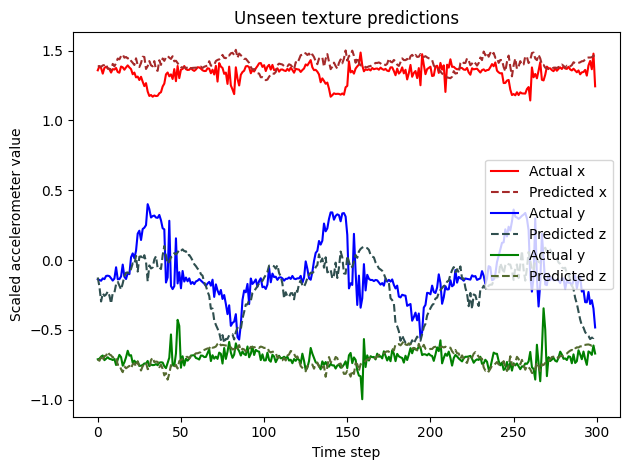

0.06727754598076967


In [55]:
pred=model(torch.tensor(test_X,dtype=torch.float32).to(device)).cpu().detach().numpy()
mse=mean_squared_error(test_y,pred)
plt.plot(test_y[300:600,0],c="r",label="Actual x")
plt.plot(pred[300:600,0],"--",c="brown",label="Predicted x")
plt.plot(test_y[300:600,1],c="b",label="Actual y")
plt.plot(pred[300:600,1],"--",c="darkslategray",label="Predicted z")
plt.plot(test_y[300:600,2],c="g",label="Actual y")
plt.plot(pred[300:600,2],"--",c="darkolivegreen",label="Predicted z")
plt.xlabel("Time step")
plt.ylabel("Scaled accelerometer value")
plt.title("Unseen texture predictions")
plt.legend()
plt.tight_layout()
plt.savefig("/its/home/drs25/GonkRobot/assets/unseenpreds.pdf")
plt.show()
print(mse)

## Residual plot

(1600, 3) (1600, 3)


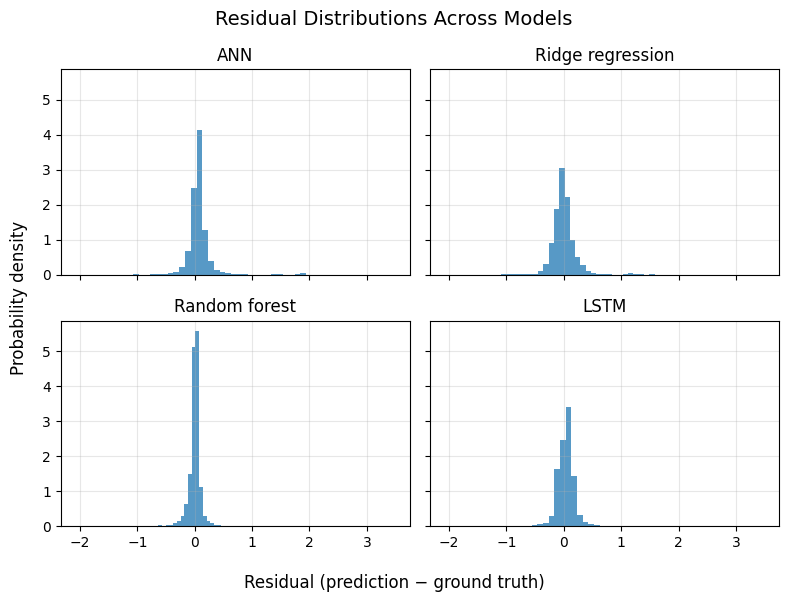

In [179]:
examples=[examples_ann,examples_r,examples_rf,examples_lstm]
targets=[y for i in range(4)]
print(examples[0].shape,targets[0].shape)
model_names = [
    "ANN",
    "Ridge regression",
    "Random forest",
    "LSTM"
]

fig, axs = plt.subplots(
    2, 2,
    figsize=(8, 6),
    sharex=True,
    sharey=True
)

axs = axs.flatten()

# -------- compute global histogram limits --------
all_residuals = []

for pred, tgt in zip(examples, targets):
    res = pred - tgt
    all_residuals.append(res.flatten())

all_residuals = np.concatenate(all_residuals)

xmin = np.min(all_residuals)
xmax = np.max(all_residuals)

# -------- plot histograms --------
for i, (pred, tgt) in enumerate(zip(examples, targets)):

    residuals = (pred - tgt).flatten()

    axs[i].hist(
        residuals,
        bins=60,
        density=True,
        alpha=0.75
    )

    axs[i].set_title(model_names[i])
    axs[i].grid(True, alpha=0.3)
    axs[i].set_xlim(xmin, xmax)

# -------- global labels --------
fig.supxlabel("Residual (prediction − ground truth)")
fig.supylabel("Probability density")

fig.suptitle(
    "Residual Distributions Across Models",
    fontsize=14
)

plt.tight_layout()
plt.savefig(
    "/its/home/drs25/GonkRobot/assets/residual.pdf",
    bbox_inches="tight"
)
plt.show()

## Classify edges

This section we experiment with a regression model to classify simply where an edge is

In [26]:
from sklearn.linear_model import RidgeClassifier
from sklearn import svm
#filepath="/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/edges/"
if sys.platform.startswith('win'): filepath="C:/Users/dexte/Documents/GitHub/TactileSensor/Code/Data collection/edges/"
def load_edges(datapath="/its/home/drs25/GonkRobot/Data/"):
    names = [
        "east", "north-east", "north-west", "north",
        "south-east", "south-west", "south", "west"
    ]

    X_all = []
    y_all = []

    for i, name in enumerate(names):
        X = np.load(datapath + name + ".npy")

        # keep frames that contain strong edges
        mask = np.max(X, axis=(1)) > 6900

        X = X[mask]

        y = np.full(len(X), i)

        X_all.append(X)
        y_all.append(y)

    X = np.concatenate(X_all, axis=0)
    y = np.concatenate(y_all, axis=0)

    return X, y

#### Ridge

In [21]:
X,y=load_edges()
x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_model = RidgeClassifier(alpha=alpha)
#ridge_model = LinearRegression()
# Fit the model to the training data
ridge_model.fit(x_train, y_train)

# Make predictions on the test data
Y_pred = ridge_model.predict(x_train)
train=accuracy_score(y_train,Y_pred)
Y_pred = ridge_model.predict(x_test)
test=accuracy_score(y_test,Y_pred)
print("Train:",train*100,"Test:",test*100)

(2672, 10) (2672,)
Train: 66.58867571361722 Test: 66.9158878504673


#### Svm

In [28]:
X,y=load_edges()
x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

svm_ = svm.SVC()
#ridge_model = LinearRegression()
# Fit the model to the training data
svm_.fit(x_train, y_train)

# Make predictions on the test data
Y_pred = svm_.predict(x_train)
train=accuracy_score(y_train,Y_pred)
Y_pred = svm_.predict(x_test)
test=accuracy_score(y_test,Y_pred)
print("Train:",train*100,"Test:",test*100)

Train: 82.73280299485259 Test: 83.3644859813084


#### Random forrest

In [22]:

X,y=load_edges()
x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

alpha = 1.0  # Ridge regularization parameter (adjust as needed)
forest_model = RandomForestClassifier(n_estimators=25, random_state=42)
#ridge_model = LinearRegression()
# Fit the model to the training data
forest_model.fit(x_train, y_train)

# Make predictions on the test data
Y_pred = forest_model.predict(x_train)
train=accuracy_score(y_train,Y_pred)
Y_pred = forest_model.predict(x_test)
test=accuracy_score(y_test,Y_pred)
print("Train:",train*100,"Test:",test*100)

Train: 100.0 Test: 95.88785046728971


### Nueral model

#### Visualise

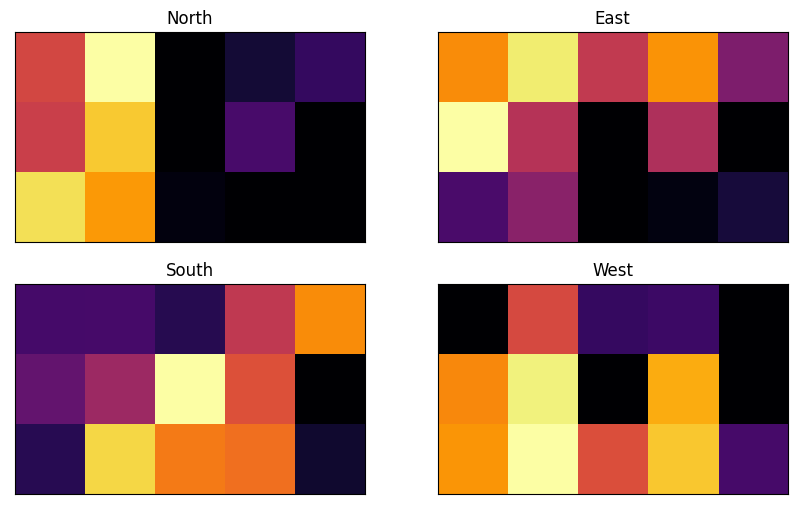

In [26]:
x=np.load(filepath+"xdata_soft.npy")
y=np.load(filepath+"ydata1_soft.npy")

#mean_values = np.mean(x, axis=1, keepdims=True)
#std_dev_values = np.std(x, axis=1, keepdims=True)
#x = (x - mean_values) / std_dev_values

n=np.zeros_like(x[0])
s=np.zeros_like(x[0])
w=np.zeros_like(x[0])
e=np.zeros_like(x[0])
for i in range(len(x)):
    if list(y[i])==[1,1,0,0]: 
        sig=x[i]
        #sig[sig!=np.max(sig)]=0
        n+=sig
    elif list(y[i])==[0,1,1,0]: 
        sig=x[i]
        #sig[sig!=np.max(sig)]=0
        e+=sig
    elif list(y[i])==[0,0,1,1]: 
        sig=x[i]
        #sig[sig!=np.max(sig)]=0
        s+=sig
    elif list(y[i])==[1,0,0,1]: 
        sig=x[i]
        #sig[sig!=np.max(sig)]=0
        w+=sig

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0][0].imshow(n,cmap='inferno')
axs[0][0].set_title("North")
axs[0][0].xaxis.set_visible(False)
axs[0][0].yaxis.set_visible(False)

axs[0][1].imshow(e,cmap='inferno')
axs[0][1].set_title("East")
axs[0][1].xaxis.set_visible(False)
axs[0][1].yaxis.set_visible(False)

axs[1][0].imshow(s,cmap='inferno')
axs[1][0].set_title("South")
axs[1][0].xaxis.set_visible(False)
axs[1][0].yaxis.set_visible(False)

axs[1][1].imshow(w,cmap='inferno')
axs[1][1].set_title("West")
axs[1][1].xaxis.set_visible(False)
axs[1][1].yaxis.set_visible(False)

plt.show()

## Visualisers

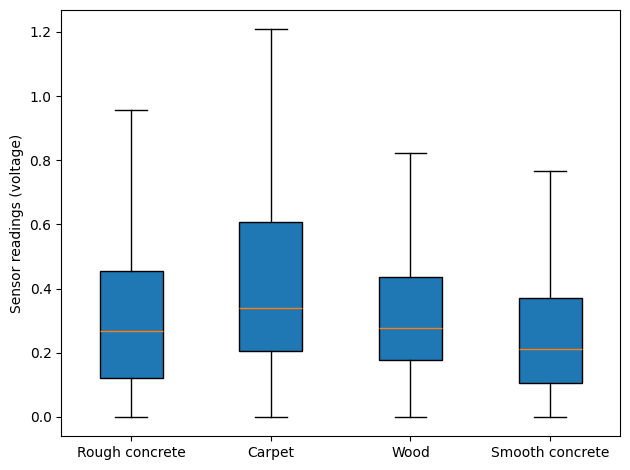

In [12]:
# box plot 
values=[(concrete_X.flatten()*3.3)/65530,(carpet_x.flatten()*3.3)/65530,(wood_X.flatten()*3.3)/65530,(smooth_X.flatten()*3.3)/65530]
names=["Rough concrete","Carpet","Wood","Smooth concrete"]

fig, ax = plt.subplots()
ax.set_ylabel('Sensor readings (voltage)')

bplot = ax.boxplot(values,
                   patch_artist=True,  # fill with color
                   tick_labels=names,showfliers=False)  # will be used to label x-ticks

plt.tight_layout()
plt.savefig("/its/home/drs25/GonkRobot/assets/boxplot.pdf")
plt.show()